In [1]:
import os
import copy
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

import hls4ml
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute
from hls4ml.model.types import FixedPrecisionType, RoundingMode, SaturationMode
from hls4ml.model.attributes import Attribute

import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client

import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

# Source the Vivado path
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

np.random.seed(0)
tf.random.set_seed(0)


2025-01-31 15:52:41.916653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 15:52:41.990116: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 15:52:41.992892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-31 15:52:41.992906: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Globals

In [2]:
IN_ROWS = 100
IN_COLS = 160
OUT_ROWS = 48
OUT_COLS = 48
Y1 = 10
X1 = 10
Y2 = Y1 + OUT_ROWS
X2 = X1 + OUT_COLS
CROP_COORDS_HARD = np.array([Y1, X1, Y2, X2])
NUM_CROPS = 1

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = 15 # int(np.log2(IN_ROWS*IN_COLS)) + 1 
    FP_TOTAL = FP_FRAC + FP_INT + 1 # We'll keep it signed for simplicity
    DATA_STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    DATA_STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    DATA_STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

SMALL_MODEL = True
if SMALL_MODEL:
    MODEL_STRING_INSERT = "_SMALL"
else:
    MODEL_STRING_INSERT = ""

REUSE_FACTOR = 32

print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")
print(f"MODEL_STRING_INSERT: {MODEL_STRING_INSERT}")
print(f"DATA_STRING_INSERT: {DATA_STRING_INSERT}")

os.makedirs("tb_data", exist_ok=True)
os.makedirs("tb_data/float32", exist_ok=True)
os.makedirs(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", exist_ok=True)

FP_TOTAL: 16
FP_INT: 15
FP_FRAC: 0
MODEL_STRING_INSERT: _SMALL
DATA_STRING_INSERT: _INDEX


Helper functions

In [3]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)

# 1. Generate, save testbench data

Want pre-crop and postcrop, don't care about output of model right now

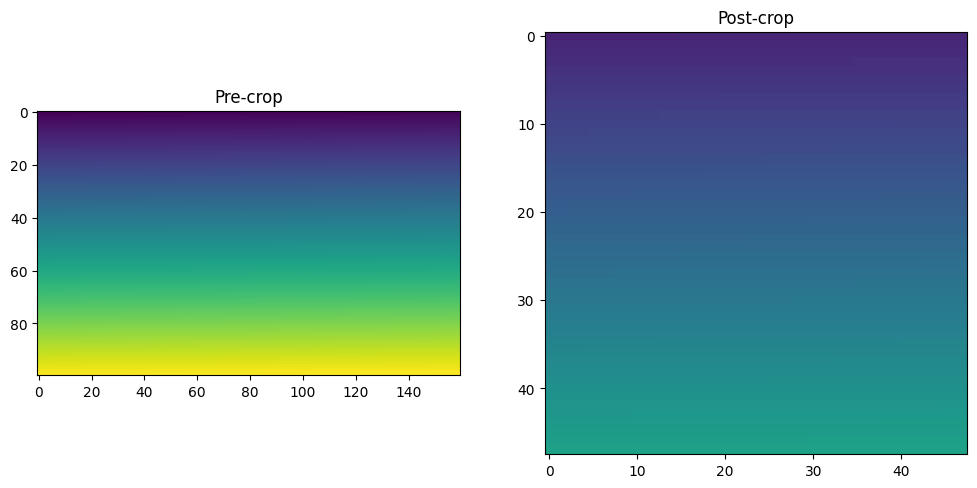

In [4]:
img_precrop_float = np.array([i for i in range(IN_ROWS*IN_COLS)]).reshape((IN_ROWS, IN_COLS)).astype(np.float32)
fpath_img_precrop = os.path.join(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", f"img_precrop{DATA_STRING_INSERT}_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin")
with open(fpath_img_precrop, "w") as f:
    for row in img_precrop_float:
        for val in row:
            val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
            f.write(f"{val_fixed}\n")

img_postcrop_float = img_precrop_float[Y1:Y2, X1:X2].astype(np.float32)
fpath_img_postcrop = os.path.join(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", f"img_postcrop{DATA_STRING_INSERT}_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin")
with open(fpath_img_postcrop, "w") as f:
    for row in img_postcrop_float:
        for val in row:
            val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
            f.write(f"{val_fixed}\n")

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.imshow(img_precrop_float, vmin=0, vmax=IN_ROWS*IN_COLS)
ax1.set_title("Pre-crop")
ax2.imshow(img_postcrop_float, vmin=0, vmax=IN_ROWS*IN_COLS)
ax2.set_title("Post-crop")
plt.show(fig)
plt.close(fig)

# 2. Generate Keras model

In [5]:
if SMALL_MODEL:
    model = tf.keras.Sequential(
        [   
            tf.keras.layers.Conv2D(filters=2, kernel_size=5, strides=1, padding='valid', input_shape=(OUT_ROWS, OUT_COLS, 1)) # (batch_size, height, width, channels)
            # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
            , tf.keras.layers.ReLU()
            , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

            , tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding='valid')
            # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
            , tf.keras.layers.ReLU()
            , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

            , tf.keras.layers.Flatten()
            , tf.keras.layers.Dense(units=98, activation='relu')
            , tf.keras.layers.Dense(units=52, activation='relu')
            , tf.keras.layers.Dense(units=5)
        ]
    )
    
else:
    model = tf.keras.Sequential(
        [   
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(OUT_ROWS, OUT_COLS, 1)) # (batch_size, height, width, channels)
            # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
            , tf.keras.layers.ReLU()
            , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

            , tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')
            # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
            , tf.keras.layers.ReLU()
            , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

            , tf.keras.layers.Flatten()
            , tf.keras.layers.Dense(units=98, activation='relu')
            , tf.keras.layers.Dense(units=52, activation='relu')
            , tf.keras.layers.Dense(units=5)
        ]
    )

model_checkpoint_path = f"GaussianModel_untrained{MODEL_STRING_INSERT}.keras"
model.compile()
print(f"n_params = {model.count_params()}")
losses_g = []

# Skip training for now
model.save(model_checkpoint_path)
print(f"\nSaved model to {model_checkpoint_path}")
model.summary()

n_params = 8737

Saved model to GaussianModel_untrained_SMALL.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 2)         52        
                                                                 
 re_lu (ReLU)                (None, 44, 44, 2)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 2)           38        
                                                                 
 re_lu_1 (ReLU)              (None, 9, 9, 2)           0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 2)         

2025-01-31 15:52:58.895790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-31 15:52:58.895962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-31 15:52:58.896038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-01-31 15:52:58.896077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-01-31 15:52:58.896114: W tensorf

In [6]:
output_float = model(img_postcrop_float.reshape((1, OUT_ROWS, OUT_COLS))).numpy().squeeze()
print(f"output_float: {output_float}")


output_float: [ -665.6089    246.73236 -1635.1891   1339.9806   -264.44592]


# 3. Generate hls4ml model

In [ ]:
# Generate the configuration from the Keras model
config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend="Vivado")
config['Model']['Precision']['default'] = f"ap_fixed<{FP_TOTAL},{FP_INT}>"
config['Model']['ReuseFactor'] = REUSE_FACTOR
config['Model']['Strategy'] = 'Resource'

# Attempt conversion on simplified model
output_dir = f"hls_model/cnn_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}_ap_fixed_{FP_TOTAL}_{FP_INT}_RF{REUSE_FACTOR}{MODEL_STRING_INSERT}"
hls_model = hls4ml.converters.convert_from_keras_model(
    model, 
    hls_config=config, 
    output_dir=output_dir, 
    backend="Vivado",
    part='xcku035-fbva676-2-e', 
    io_type="io_stream"
)

hls_model.compile()

print("")
print(hls_model.config.config['OutputDir'])

Interpreting Sequential
Topology:
Layer name: conv2d_input, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 2]
Layer name: re_lu, layer type: Activation, input shapes: [[None, 44, 44, 2]], output shape: [None, 44, 44, 2]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 2]], output shape: [None, 11, 11, 2]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 11, 11, 2]], output shape: [None, 9, 9, 2]
Layer name: re_lu_1, layer type: Activation, input shapes: [[None, 9, 9, 2]], output shape: [None, 9, 9, 2]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 9, 9, 2]], output shape: [None, 4, 4, 2]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 2]], output shape: [None, 32]
Layer name: dense, layer type: Dense, input shapes: [[None, 32]], output shape:

In [9]:
output_hls = hls_model.predict(np.ascontiguousarray(img_postcrop_float))
print(output_hls)

[   950.5   3804.  -14507.5 -13539.    5806. ]


In [10]:
fpath_hls_out = os.path.join(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", f"hlsout_postcrop{MODEL_STRING_INSERT}{DATA_STRING_INSERT}_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin")
with open(fpath_hls_out, "w") as f:
    for val in output_hls:
        val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
        f.write(f"{val_fixed}\n")

# 4. Build Verilog model

In [11]:
hls_model.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'aelabd' on host 'DESKTOP-Q0UCNGC.' (Linux_x86_64 version 5.15.133.1-microsoft-standard-WSL2) on Fri Jan 31 15:54:31 PST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04 LTS
INFO: [HLS 200-10] In directory '/home/aelabd/RHEED/crop_verilog/hls_model/cnn_100x160_to_48x48x1_ap_fixed_16_15_RF32_SMALL'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/aelabd/RHEED/crop_verilog/hls_model/cnn_100x160_to_48x48x1_ap_fixed_16_15_RF32_SMALL/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.338',
  'BestLatency': '71445',
  'WorstLatency': '71446',
  'IntervalMin': '6914',
  'IntervalMax': '71426',
  'BRAM_18K': '109',
  'DSP': '210',
  'FF': '33399',
  'LUT': '74041',
  'URAM': '0',
  'AvailableBRAM_18K': '1080',
  'AvailableDSP': '1700',
  'AvailableFF': '406256',
  'AvailableLUT': '203128',
  'AvailableURAM': '0'},
 'VivadoSynthReport': {'LUT': '23237',
  'FF': '29488',
  'BRAM_18K': '10',
  'DSP48E': '210'}}

In [16]:
hls4ml.report.read_vivado_report(hls_model.config.config['OutputDir'])

Found 1 solution(s) in hls_model/cnn_100x160_to_48x48x1_ap_fixed_16_15_RF32_SMALL/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Jan 31 15:56:01 2025

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku035-fbva676-2-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.338|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-------+-------+------+-------+----------+
    |    Latency    |   Interval   | Pipeline |
    |  min  |  max  |  min |  max  |   Type   |
    +-------+-------+------+-------+----------+
    |  7144

# 5. Create vlog list

In [17]:
verilog_dir = os.path.join(hls_model.config.config['OutputDir'], "myproject_prj/solution1/impl/verilog")
verilog_files = [i for i in os.listdir(verilog_dir) if i.endswith(".v")]
vlog_str = ""
for vf in verilog_files:
    vlog_str += f'vlog "./{vf}"\n'

print(vlog_str)

vlog "./start_for_relu_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_2u_ReLU_config4_U0.v"
vlog "./myproject_mux_325_16_1_1.v"
vlog "./fifo_w16_d1936_A.v"
vlog "./pooling2d_cl_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_2u_config5_s.v"
vlog "./dense_wrapper_ap_fixed_16_15_5_3_0_ap_fixed_16_15_5_3_0_config13_s.v"
vlog "./start_for_dense_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_98u_config11_U0.v"
vlog "./shift_line_buffer_array_ap_fixed_16_15_5_3_0_2u_config6_s.v"
vlog "./pooling2d_cl_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_2u_config9_s_line_bpcA.v"
vlog "./dense_wrapper_ap_fixed_16_15_5_3_0_ap_fixed_16_15_5_3_0_config15_s_w15_V.v"
vlog "./dense_resource_ap_fixed_ap_fixed_16_15_5_3_0_config2_mult_s.v"
vlog "./dense_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_98u_config11_s.v"
vlog "./start_for_relu_array_ap_fixed_98u_array_ap_fixed_16_15_5_3_0_98u_relu_config1tde.v"
vlog "./relu_array_ap_fixed_2u_array_ap_fixed_16_15_5_3_0_2u_ReLU_config4_s.v"
vlog "./dense_resource_ap_fixed_ap

# 6. Generate command to copy hls-model directory

In [18]:
source_dir = verilog_dir + "/*"
dest_dir = os.path.join(f"/mnt/c/Users/abdel/OneDrive/Documents/RHEED/crop_verilog/testbench_gauss_only/ap_fixed_{FP_TOTAL}_{FP_INT}{MODEL_STRING_INSERT}")

copy_hls_str = "cp -r" + f" {source_dir}" + f" {dest_dir}"
print(copy_hls_str)

cp -r hls_model/cnn_100x160_to_48x48x1_ap_fixed_16_15_RF32_SMALL/myproject_prj/solution1/impl/verilog/* /mnt/c/Users/abdel/OneDrive/Documents/RHEED/crop_verilog/testbench_gauss_only/ap_fixed_16_15_SMALL


# 7. And to copy tb_data directory

In [19]:
source_tb_data_dir = f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}/*"
dest_tb_data_dir = os.path.join(f"/mnt/c/Users/abdel/OneDrive/Documents/RHEED/crop_verilog/testbench_gauss_only/ap_fixed_{FP_TOTAL}_{FP_INT}{MODEL_STRING_INSERT}/tb_data")

copy_tb_data_str = "cp -r" + f" {source_tb_data_dir}" + f" {dest_tb_data_dir}"
print(copy_tb_data_str)

cp -r tb_data/ap_fixed_16_15/* /mnt/c/Users/abdel/OneDrive/Documents/RHEED/crop_verilog/testbench_gauss_only/ap_fixed_16_15_SMALL/tb_data
